In [1]:
import numpy as np
import pandas as pd
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/Volumes/Storage/goinfre/ptyshevs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Volumes/Storage/goinfre/ptyshevs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Volumes/Storage/goinfre/ptyshevs/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Volumes/St

In [5]:
import pyximport
pyximport.install(language_level=3)
import life

In [36]:
def create_model():
    nn = Sequential()
    nn.add(Dense(400, input_shape=(400,), activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='relu'))
    nn.add(Dense(400, activation='sigmoid'))
    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mae'])
    return nn

In [37]:
es = EarlyStopping(monitor='loss', patience=6, min_delta=0.01)

In [38]:
model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_10 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_11 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_12 (Dense)             (None, 400)               160400    
Total params: 641,600
Trainable params: 641,600
Non-trainable params: 0
_________________________________________________________________


In [42]:
NROW, NCOL = 20, 20

def generate_samples(delta=1, n=32):
    """
    Generate batch of samples
    
    @return: (end_frames, start_frames)
    """
    batch = np.split(np.random.binomial(1, 0.5, (NROW * n, NCOL)).astype('uint8'), n)
    Yy = [life.make_move(state, 5) for state in batch]
    Xx = [life.make_move(state, 1) for state in Yy]
    Y = np.array([y.ravel() for y in Yy])
    X = np.array([x.ravel() for x in Xx])
    return X, Y
    

def data_generator(delta=1, batch_size=32):
    """
    Can be used along with .fit_generator to generate training samples on the fly
    """
    while True:
        batch = np.split(np.random.binomial(1, 0.5, (NROW * batch_size, NCOL)).astype('uint8'), batch_size)
        Yy = [life.make_move(state, 5) for state in batch]
        Xx = [life.make_move(state, delta) for state in Yy]

        Y = np.array([y.ravel() for y in Yy])
        X = np.array([x.ravel() for x in Xx])
        yield X, Y

In [43]:
model.fit_generator(data_generator(), steps_per_epoch=500, epochs=10, verbose=2)

Epoch 1/10
 - 3s - loss: 0.4640 - acc: 0.7755 - mean_absolute_error: 0.3027
Epoch 2/10
 - 3s - loss: 0.4514 - acc: 0.7788 - mean_absolute_error: 0.2942
Epoch 3/10
 - 3s - loss: 0.4430 - acc: 0.7814 - mean_absolute_error: 0.2886
Epoch 4/10
 - 3s - loss: 0.4363 - acc: 0.7838 - mean_absolute_error: 0.2841
Epoch 5/10
 - 3s - loss: 0.4318 - acc: 0.7853 - mean_absolute_error: 0.2811
Epoch 6/10
 - 3s - loss: 0.4291 - acc: 0.7863 - mean_absolute_error: 0.2793
Epoch 7/10
 - 4s - loss: 0.4258 - acc: 0.7875 - mean_absolute_error: 0.2770
Epoch 8/10
 - 3s - loss: 0.4228 - acc: 0.7891 - mean_absolute_error: 0.2748
Epoch 9/10
 - 3s - loss: 0.4205 - acc: 0.7899 - mean_absolute_error: 0.2734
Epoch 10/10
 - 3s - loss: 0.4181 - acc: 0.7912 - mean_absolute_error: 0.2717


In [44]:
X, Y = generate_samples()

In [45]:
xtest = X[0].reshape((20, 20))

In [46]:
ytest = Y[0].reshape((20, 20))

In [47]:
from viz import show_field

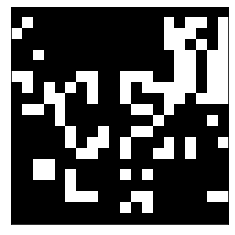

In [48]:
show_field(xtest)

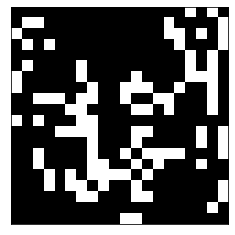

In [49]:
show_field(ytest)

In [17]:
xt = np.concatenate((np.zeros((20, 1), 'uint8'), np.ones((20, 1), 'uint8'), xtest), axis=1).ravel()

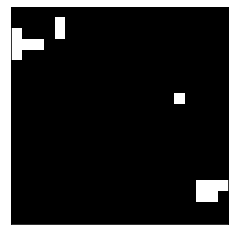

In [18]:
y_pred = model.predict(xt[np.newaxis, :]).round(0).reshape((20, 22))
show_field(y_pred.reshape((20, 22))[:, 2:].ravel())

In [20]:
test_df = pd.read_csv('resources/test.csv', index_col=0)

In [57]:
submit_df = pd.DataFrame(model.predict(test_df.iloc[:, 1:]).round(0).astype('uint8'), 
                         index=test_df.index, columns=['start.' + str(_) for _ in range(1, 401)])

In [58]:
submit_df.to_csv('nn_submit.csv')